In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Input
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.layers import BatchNormalization, Conv1D, MaxPooling1D
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam, SGD

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Actual')
    plt.plot(predicted, color='blue',label='Predicted')
    plt.title('Model Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


def plot(data):
    plt.plot(data.X, data.Y, color='blue', label='Test')
    plt.title('Model Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

In [3]:
# Preprocessing of Data

dataset = pd.read_csv('tests/food_data.csv', index_col='Date', parse_dates=['Date'])
train_data, test_data = train_test_split(dataset, test_size = 0.3, shuffle = False)
training_set = train_data.iloc[:,0:1].values
test_set = test_data.iloc[:,0:1].values
split_seconds = "2019-04-04 01:00:20"
#training_set = dataset[:split_seconds].iloc[:,0:1].values
#test_set = dataset[split_seconds:].iloc[:,0:1].values
#test = dataset[:split_seconds].iloc[:,1:2]
print(training_set.shape)
print(test_set.shape)
print(training_set[:10])

(175, 1)
(75, 1)
[[10.  ]
 [ 9.96]
 [ 9.92]
 [ 9.88]
 [ 9.84]
 [ 9.8 ]
 [ 9.76]
 [ 9.72]
 [ 9.68]
 [ 9.64]]


# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,training_set.shape[0]):
    X_train.append(training_set[i-60:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)

In [4]:
# Scaling the training set
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)
print(training_set.shape)

(175, 1)


In [5]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [6]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

In [7]:
def build_attention_model(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, dense_units=128, dr=0.1, use_attention=True):
    max_len = X_train.shape[1]
    inp = Input(shape = (max_len,1))
    x_gru = LSTM(units * 2, return_sequences = True)(inp)
    if use_attention:
        x_att = Attention(max_len)(x_gru)
        x = Dropout(dr)(Dense(dense_units, activation='relu') (x_att))
    else:
        x_att = Flatten() (x_gru)
        x = Dropout(dr)(Dense(dense_units, activation='relu') (x_att))

    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["mean_squared_error"])
    model.summary()
    return model

In [12]:
attention_file_path = "model_checkpoint/best_attention_model.hdf5"
check_point = ModelCheckpoint(attention_file_path, monitor = "val_mean_squared_error", verbose = 1,
                              save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_mean_squared_error", mode = "min", patience = 10)
attention_model = build_attention_model(lr = 1e-3, lr_d = 1e-7, units = 128, spatial_dr = 0.3, dense_units=25, dr=0.1, use_attention=True)
attention_history = attention_model.fit(X_train, y_train, batch_size = 60, epochs = 50, validation_split=0.1, verbose = 1, callbacks = [check_point, early_stop])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 256)           264192    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               316       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                6425      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
batch_normalization_1

In [8]:
def create_model():
    model = Sequential()
    
    # First layer with Dropout regularisation
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    model.add(Dropout(0.2))
    
    # Second layer
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    model.add(Dropout(0.2))
    
    # Third layer
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    model.add(Dropout(0.2))

    # Fourth layer
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(optimizer = SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), metrics = ["mean_squared_error"], loss='mean_squared_error')
    return model

In [9]:
file_path = "model_checkpoint/test_best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 30)
history = create_model().fit(X_train,y_train,epochs=50, batch_size=60, validation_split = 0.3, verbose = 1, callbacks= [check_point])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 80 samples, validate on 35 samples
Epoch 1/50
80/80 [==============================] - 5s 56ms/step - loss: 0.1993 - mean_squared_error: 0.1993 - val_loss: 0.0074 - val_mean_squared_error: 0.0074

Epoch 00001: val_loss improved from inf to 0.00738, saving model to model_checkpoint/test_best_model.hdf5
Epoch 2/50
80/80 [==============================] - 0s 5ms/step - loss: 0.1653 - mean_squared_error: 0.1653 - val_loss: 0.0035 - val_mean_squared_error: 0.0035

Epoch 00002: val_loss improved from 0.00738 to 0.00346, saving model to model_checkpoint/test_best_model.hdf5
Epoch 3/50
80/80 [==============================] - 0s 5ms/step - loss: 0.1124 - mean_squared_error: 0.1124 - val_loss: 0.0165 - val_mean_squared_error: 0.0165

Epoch 00003: val_loss

80/80 [==============================] - 0s 5ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.1007 - val_mean_squared_error: 0.1007

Epoch 00034: val_loss did not improve from 0.00346
Epoch 35/50
80/80 [==============================] - 0s 4ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.1018 - val_mean_squared_error: 0.1018

Epoch 00035: val_loss did not improve from 0.00346
Epoch 36/50
80/80 [==============================] - 0s 5ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.1030 - val_mean_squared_error: 0.1030

Epoch 00036: val_loss did not improve from 0.00346
Epoch 37/50
80/80 [==============================] - 0s 4ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.1047 - val_mean_squared_error: 0.1047

Epoch 00037: val_loss did not improve from 0.00346
Epoch 38/50
80/80 [==============================] - 0s 4ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.1066 - val_mean_squared_error: 0.1066

In [15]:
# Loading Models with Trained Weights of the best model with the lowest validation loss
model = create_model()
model.load_weights(file_path)
attention_model = build_attention_model(lr = 1e-3, lr_d = 1e-7, units = 128, spatial_dr = 0.3, dense_units=25, dr=0.1, use_attention=True)
attention_model.load_weights(attention_file_path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 1)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 256)           264192    
_________________________________________________________________
attention_2 (Attention)      (None, 256)               316       
_________________________________________________________________
dense_6 (Dense)              (None, 25)                6425      
_________________________________________________________________
dropout_11 (Dropout)         (None, 25)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 25)                100       
_________________________________________________________________
dense_7 (Dense)              (None, 12)                312       
__________

In [59]:
# Generating Sequences using Attention-Based Model
initial_sequence = X_train[X_train.shape[0]-1,:]
attention_sequence = []
for i in range(250):
    new_prediction = attention_model.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    attention_sequence.append(new_prediction)
attention_sequence = sc.inverse_transform(np.array(attention_sequence).reshape(250,1))

In [60]:
dataset_total = pd.concat((dataset[:split_seconds].Y,dataset[split_seconds:].Y),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [99]:
dataset_total = pd.concat((dataset["Y"][:split_seconds],dataset["Y"][split_seconds:]),axis=0)

inputs = dataset_total[len(dataset_total)-len(test_set)-60:].values
test_set = test_set.reshape(-1,1)
#inputs = test_set
inputs = inputs.reshape(-1,1)

total_scaler = MinMaxScaler()
inputs = total_scaler.fit_transform(inputs)

print(inputs.shape)
print(test_set.shape)

(1708, 1)
(1648, 1)


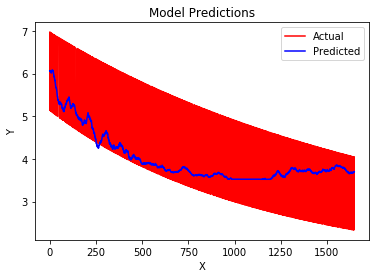

The root mean squared error is 1.1088879435017227.


In [100]:
# Preparing X_test and predicting the prices
# X_test is prepared by taking the past 60 elements of the data to predict the current data

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predictions = attention_model.predict(X_test)
predictions = total_scaler.inverse_transform(predictions)
final_predictions = [i for i in predictions]
plot_predictions(test_set, final_predictions)
return_rmse(test_set,final_predictions)

In [107]:
# Generating Sequences using LSTM Model
initial_sequence = X_train[X_train.shape[0]-1,:]
sequence = []
for i in range(test_set.shape[0]):
    new_prediction = model.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
print(sequence[:10])
#sequence = sc.inverse_transform(np.array(sequence).reshape(test_set.shape[0],1))

[array([[0.38940746]], dtype=float32), array([[0.3893688]], dtype=float32), array([[0.389331]], dtype=float32), array([[0.38931528]], dtype=float32), array([[0.38933188]], dtype=float32), array([[0.38938236]], dtype=float32), array([[0.38946277]], dtype=float32), array([[0.38956958]], dtype=float32), array([[0.38970014]], dtype=float32), array([[0.38984933]], dtype=float32)]


In [110]:
print(initial_sequence[:5])
print(X_train[0])

[[0.392643]
 [0.392643]
 [0.392643]
 [0.392643]
 [0.392643]]
[[1.        ]
 [0.99810239]
 [0.99810239]
 [0.99715452]
 [0.99242455]
 [0.99526066]
 [0.99431467]
 [0.9933693 ]
 [0.98488899]
 [0.99148043]
 [0.98113608]
 [0.97926333]
 [0.97739305]
 [0.97552522]
 [0.97365986]
 [0.97179694]
 [0.98488899]
 [0.96807846]
 [0.96622288]
 [0.96436974]
 [0.96251903]
 [0.96067076]
 [0.97926333]
 [0.97832788]
 [0.95514046]
 [0.97645883]
 [0.95146568]
 [0.9496319 ]
 [0.97365986]
 [0.94597154]
 [0.94414496]
 [0.9708664 ]
 [0.94049897]
 [0.96900716]
 [0.96807846]
 [0.96715036]
 [0.96622288]
 [0.93142562]
 [0.92961807]
 [0.96344408]
 [0.92601003]
 [0.92420954]
 [0.96067076]
 [0.92061562]
 [0.9588249 ]
 [0.91703106]
 [0.91524229]
 [0.91345585]
 [0.95514046]
 [0.90988994]
 [0.90811047]
 [0.95238347]
 [0.95146568]
 [0.90278595]
 [0.9496319 ]
 [0.94871591]
 [0.94780052]
 [0.94688573]
 [0.94597154]
 [0.94505795]]


In [114]:
print(predictions[:10])
print(test_set[:10])

[[6.0688524]
 [6.0542426]
 [6.0698338]
 [6.054254 ]
 [6.068778 ]
 [6.0519443]
 [6.0374894]
 [6.0257626]
 [6.0137944]
 [6.034317 ]]
[[6.97151905]
 [5.13945077]
 [6.96610722]
 [5.13272746]
 [6.96070176]
 [6.95800141]
 [6.95530265]
 [5.11932329]
 [6.94990988]
 [5.11264235]]


In [ ]:
print(sequence.shape)